# Analyse 1: Diachrone Frequenzdiagramme <!-- Analysis 1: Diachronic Frequencies Plots --> 

Jetzt werden wir die CONLL-Daten nehmen und einige Analysen durchführen. Unser erster Schritt wird sein, die Wort-/Lemma-Häufigkeiten für die Monate des Jahres 1918 zu plotten und zu sehen, ob sie mit den Wellen der Grippepandemie korrelieren.

<!-- Now we'll take the CONLL data and do some analysis. Our first step would be to plot word/lemma frequencies for months of year 1918 and see if they correlate with the waves of the flu pandemic --> 


## 0. Importe und Daten-Upload <!-- Imports and data upload --> 

In [ ]:
import pandas as pd

In [ ]:
import re

In [ ]:
from pathlib import Path

In [ ]:
## for interactivity in jupyter books
from bokeh.io import output_notebook, show
from bokeh.layouts import column
from bokeh.models import CustomJS, TextInput, Div

In [ ]:
conllfiles = Path(r"../data/csv")

In [ ]:
corpus_annotations = {}
for file in conllfiles.iterdir():
    if file.suffix == '.csv':
        #path = os.path.join(conllfiles, filename)  
        data = pd.read_csv(file) 
        corpus_annotations[file.name] = data

In [ ]:
corpus_metadata = pd.read_csv(Path('../data/metadata/QUADRIGA_FS-Text-01_Data01_Corpus-Table.csv'), sep=';')

In [ ]:
corpus_metadata = corpus_metadata.set_index('DC.identifier')

In [ ]:
# Ensure Bokeh output is displayed in the notebook
output_notebook()

## 1. Suche nach einem Lemma und plotte die Häufigkeit <!-- Search for a lemma and plot frequency -->

In [ ]:
class WordSearchEngine:
    
    def __init__(self, corpus_annotated, corpus_metadata, granularity_parameter='month'):
        self.granularity_parameter = granularity_parameter
        self.prepare_index_dataframe_for_search(corpus_annotated, corpus_metadata)
    
    def prepare_index_dataframe_for_search(self, corpus_annotated, corpus_metadata):
        for filename, annotated_text in corpus_annotated.items():
            txtname = filename.replace('.csv', '')
            if txtname in corpus_metadata.index:
                year, month, day, week = self.get_date_fname(txtname, corpus_metadata)
                annotated_text['month'] = month
                annotated_text['day'] = day
                annotated_text['week'] = week
        self.full_df = pd.concat(corpus_annotated.values())
        self.monthly_word_counts = self.full_df.groupby(self.granularity_parameter).count().Token
        print(f'Searching in a corpus of {self.full_df.shape[0]} word occurences')
        
    def get_date_fname(self, txtname, corpus_metadata):  
        date = corpus_metadata.loc[txtname, 'DC.date']
        date_str = str(date)
        year = date_str[:4]
        month = f"{date_str[:7]}"
        day = date_str
        # week
        date_obj = pd.to_datetime(date_str)
        week_number = f'{year}_week_{date_obj.weekofyear}'
        return year, month, day, week_number 
        
    def search_and_plot(self, search_terms, absolute_freqs=False):
        search_terms = search_terms.split(',')
        search_terms = [x.strip() for x in search_terms]
        result = self.full_df.query(f'Lemma.isin({search_terms})')
        if absolute_freqs:
            absolute_freqs = result.groupby(self.granularity_parameter).count().Lemma
            absolute_freqs.plot(title=f'frequency of {search_term}');
            #print(absolute_freqs)
        else:
            #print(monthly_word_counts)
            relative_freqs = result.groupby(self.granularity_parameter).count().Lemma/self.monthly_word_counts
            relative_freqs = relative_freqs.fillna(0)
            #print(relative_freqs)
            relative_freqs.plot(title=f'frequency of {search_terms}')
        
        

            

In [ ]:
search_terms = TextInput(value='Grippe, Krankheit', 
                                 title="Geben Sie die zu suchenden Wörter ein und trennen Sie sie durch Kommas, wenn es mehrere sind:") #input('Insert words to search, split by comma if more than one: ')

search_terms_str = search_terms.value.strip()
# JavaScript callback to update the in Jupyter Book
rewrite_var_after_input = CustomJS(args=dict(text_input=search_terms), code="""
    var word = text_input.value.trim();
    console.log('Input value:', word);
    function sendToPython(){
    var kernel = IPython.notebook.kernel;
    kernel.execute("search_terms_str = '" + word + "'");
    }
    sendToPython();
""")



search_terms.js_on_change('value', rewrite_var_after_input)

# Layout and display
layout = column(search_terms)

show(layout)

In [ ]:
engine = WordSearchEngine(corpus_annotations, corpus_metadata)

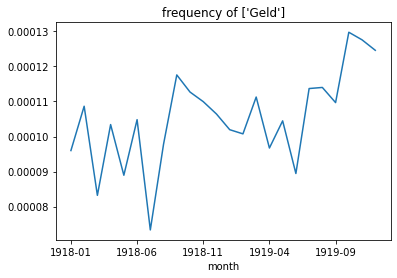

In [148]:
%matplotlib inline
engine.search_and_plot(search_terms_str)

## 3. Diskussion des Zwischenergebnisses

Ist dieses Ergebnis sinnvoll und spiegelt es tatsächlich etwas wider? Eine Möglichkeit, dies zu überprüfen, besteht darin, unser Diagramm mit den tatsächlichen Daten über die Intensität der Pandemie zu vergleichen.

In (Taubenberger, J. K., & Morens, D. M. (2006). 1918 Influenza: the Mother of All Pandemics. Emerging Infectious Diseases, 12(1), 15-22. https://doi.org/10.3201/eid1201.050979) wird festgestellt, dass 'The first pandemic influenza wave appeared in the spring of 1918, followed in rapid succession by much more fatal second and third waves in the fall and winter of 1918–1919, respectively'('Die erste Pandemie-Influenza-Welle im Frühjahr 1918 auftrat, gefolgt von weitaus tödlicheren zweiten und dritten Wellen im Herbst und Winter 1918–1919'). Sie ergänzen diese Aussage auch mit einem Diagramm aus einem früheren Papier (Jordan E. (1927). Epidemic influenza: a survey. Chicago: American Medical Association):

<!-- ## 3. Discussion of the intermediate result 

Is this result meaningful and does it actually reflect something? One way to check that is to compare our plot with the actual data about the intensity of the pandemic. 

In (Taubenberger, J. K., & Morens, D. M. (2006). 1918 Influenza: the Mother of All Pandemics. Emerging Infectious Diseases, 12(1), 15-22. https://doi.org/10.3201/eid1201.050979) it is stated that 'The first pandemic influenza wave appeared in the spring of 1918, followed in rapid succession by much more fatal second and third waves in the fall and winter of 1918–1919, respectively'. They also supplement this statement with a plot from an earlier paper (Jordan  E. (1927). Epidemic influenza: a survey. Chicago: American Medical Association): --> 

<img src="https://wwwnc.cdc.gov/eid/images/05-0979-F1.gif">

Unsere zwei Wellen von Erwähnungen des Wortes 'Grippe' scheinen den Sterblichkeitszahlen zu entsprechen, was darauf hindeuten könnte, dass die Methode, obwohl sehr einfach, funktioniert und dass historische Ereignisse manchmal in Wortfrequenzzählungen reflektiert werden können... Die dritte Welle scheint nicht reproduziert zu werden, was eine weitere Untersuchung erfordert. Eine Hypothese könnte sein, dass, ähnlich wie bei der COVID-Pandemie, neue Krankheitswellen irgendwann aufhören, die Aufmerksamkeit der Öffentlichkeit zu erregen. Beispielsweise waren die COVID-Wellen im Jahr 2021 stärker als die im Jahr 2020, aber die Berichterstattung in den Nachrichten nahm bereits ab. Dies könnte besonders für Anfang 1919 zutreffen, als nach dem Verlust des Krieges und der Revolution von 1918 Grippetodesfälle kein Nachrichtenthema mehr waren.
<!-- Our two waves of mentions of the word 'Grippe' seem to correspond to the mortality figures, which could indicate that the method, albeit very simple, works and that historical events can sometimes be reflected in word frequency counts... The third wave does not seem to rerpoduce, which calls for further investigation. One hypothesis could be that, like with the COVID pandemic, at some point new waves of illness stop attracting public's attention. E.g. the 2021 covid waves were stronger than the 2020, but the news coverage was already waning. This coul be especially true for early 1919, when after the loss of the war and the 1918 revolution grippe deaths were not a news topic anymore. -->